<a href="https://colab.research.google.com/github/uol-mediaprocessing/group-projects-sudoku-solver/blob/master/main_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install import_ipynb
import import_ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2975 sha256=c5f5c027fac0bd3ee4f7f70bc97fbc1968344a5b792451fa4a6cf29917c9d458
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [3]:
!wget https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-sudoku-solver/master/defs_common.ipynb -O "defs_common.ipynb"
from defs_common import *

--2020-01-05 10:37:26--  https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-sudoku-solver/master/defs_common.ipynb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6564 (6.4K) [text/plain]
Saving to: ‘defs_common.ipynb’

defs_common.ipynb   100%[===================>]   6.41K  --.-KB/s    in 0s      

2020-01-05 10:37:26 (90.2 MB/s) - ‘defs_common.ipynb’ saved [6564/6564]

importing Jupyter notebook from defs_common.ipynb


In [4]:
import pandas as pd
import numpy as np
import PIL
import cv2 as cv
from keras import models, layers, callbacks
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [5]:
!cp "./drive/My Drive/sudoku_acquisition_output.bz2" "./sudoku_acquisition_output.bz2"
acquisition_output = pd.read_pickle("./sudoku_acquisition_output.bz2")
acquisition_output

,input_image,input_digits,training
input_filename,,,
./v2_train/image1059.jpg,"[[[172, 171, 159], [174, 170, 165], [174, 170,...","[[0, 3, 0, 1, 4, 8, 2, 0, 0], [0, 4, 2, 0, 0, ...",True
./v2_train/image26.jpg,"[[[120, 130, 131], [119, 129, 130], [117, 127,...","[[6, 0, 1, 0, 8, 5, 0, 0, 4], [0, 0, 0, 3, 0, ...",True
./v2_train/image41.jpg,"[[[142, 162, 150], [142, 162, 150], [142, 162,...","[[7, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 1, 4, 0, ...",True
./v2_train/image19.jpg,"[[[148, 166, 154], [148, 166, 154], [147, 165,...","[[6, 0, 1, 0, 8, 5, 0, 0, 4], [0, 0, 0, 3, 0, ...",False
./v2_train/image22.jpg,"[[[149, 166, 156], [149, 166, 156], [149, 166,...","[[6, 0, 1, 0, 8, 5, 0, 0, 4], [0, 0, 0, 3, 0, ...",False
...,...,...,...
./dataset/009000800/IMG_8812.JPG,"[[[93, 98, 90], [95, 96, 95], [93, 95, 94], [9...","[[0, 0, 9, 0, 0, 0, 8, 0, 0], [0, 6, 0, 0, 0, ...",True
./dataset/009000800/IMG_8817.JPG,"[[[195, 195, 197], [196, 194, 200], [195, 196,...","[[0, 0, 9, 0, 0, 0, 8, 0, 0], [0, 6, 0, 0, 0, ...",True
./dataset/009000800/IMG_8822.JPG,"[[[15, 15, 14], [15, 15, 17], [14, 14, 16], [1...","[[0, 0, 9, 0, 0, 0, 8, 0, 0], [0, 6, 0, 0, 0, ...",True


In [6]:
!cp "./drive/My Drive/sudoku_extraction_output.bz2" "./sudoku_extraction_output.bz2"
extraction_output = pd.read_pickle("./sudoku_extraction_output.bz2")
extraction_output

cell_image
input_filename                   cell_row cell_col                                                   
./v2_train/image1059.jpg         0        0         [[[89, 78, 76], [71, 59, 58], [68, 55, 55], [6...
                                          1         [[[68, 56, 54], [74, 61, 59], [75, 61, 59], [7...
                                          2         [[[69, 57, 55], [75, 64, 61], [79, 68, 65], [7...
                                          3         [[[75, 65, 63], [84, 75, 73], [87, 77, 75], [9...
                                          4         [[[73, 65, 66], [86, 78, 78], [90, 84, 81], [9...
...                                                                                               ...
./dataset/009000800/IMG_8824.JPG 8        4         [[[115, 107, 105], [106, 98, 96], [156, 148, 1...
                                          5         [[[165, 156, 157], [170, 161, 162], [169, 160,...
                                          6         [[[167, 158, 160], [168, 158, 160], [168, 157,...
                                          7         [[[162, 153, 156], [162, 153, 156], [162, 152,...
                                          8         [[[150, 142, 146], [151, 142, 146], [150, 141,...

[13122 rows x 1 columns]

In [7]:
dataset = extraction_output.copy()
dataset["input_digit"] = [acquisition_output.loc[filename]["input_digits"][row][col] for filename, row, col in extraction_output.index]
dataset["training"] = [acquisition_output.loc[filename]["training"] for filename, _, _ in extraction_output.index]
dataset

cell_image  ...  training
input_filename                   cell_row cell_col                                                     ...          
./v2_train/image1059.jpg         0        0         [[[89, 78, 76], [71, 59, 58], [68, 55, 55], [6...  ...      True
                                          1         [[[68, 56, 54], [74, 61, 59], [75, 61, 59], [7...  ...      True
                                          2         [[[69, 57, 55], [75, 64, 61], [79, 68, 65], [7...  ...      True
                                          3         [[[75, 65, 63], [84, 75, 73], [87, 77, 75], [9...  ...      True
                                          4         [[[73, 65, 66], [86, 78, 78], [90, 84, 81], [9...  ...      True
...                                                                                               ...  ...       ...
./dataset/009000800/IMG_8824.JPG 8        4         [[[115, 107, 105], [106, 98, 96], [156, 148, 1...  ...      True
                                          5         [[[165, 156, 157], [170, 161, 162], [169, 160,...  ...      True
                                          6         [[[167, 158, 160], [168, 158, 160], [168, 157,...  ...      True
                                          7         [[[162, 153, 156], [162, 153, 156], [162, 152,...  ...      True
                                          8         [[[150, 142, 146], [151, 142, 146], [150, 141,...  ...      True

[13122 rows x 3 columns]

# Introduction

# Splitting dataset into train and test subsets

In [8]:
train = dataset[dataset["training"] == True]
print("Training dataset contains %d samples!" % len(train))

Training dataset contains 11097 samples!


In [9]:
train

cell_image  ...  training
input_filename                   cell_row cell_col                                                     ...          
./v2_train/image1059.jpg         0        0         [[[89, 78, 76], [71, 59, 58], [68, 55, 55], [6...  ...      True
                                          1         [[[68, 56, 54], [74, 61, 59], [75, 61, 59], [7...  ...      True
                                          2         [[[69, 57, 55], [75, 64, 61], [79, 68, 65], [7...  ...      True
                                          3         [[[75, 65, 63], [84, 75, 73], [87, 77, 75], [9...  ...      True
                                          4         [[[73, 65, 66], [86, 78, 78], [90, 84, 81], [9...  ...      True
...                                                                                               ...  ...       ...
./dataset/009000800/IMG_8824.JPG 8        4         [[[115, 107, 105], [106, 98, 96], [156, 148, 1...  ...      True
                                          5         [[[165, 156, 157], [170, 161, 162], [169, 160,...  ...      True
                                          6         [[[167, 158, 160], [168, 158, 160], [168, 157,...  ...      True
                                          7         [[[162, 153, 156], [162, 153, 156], [162, 152,...  ...      True
                                          8         [[[150, 142, 146], [151, 142, 146], [150, 141,...  ...      True

[11097 rows x 3 columns]

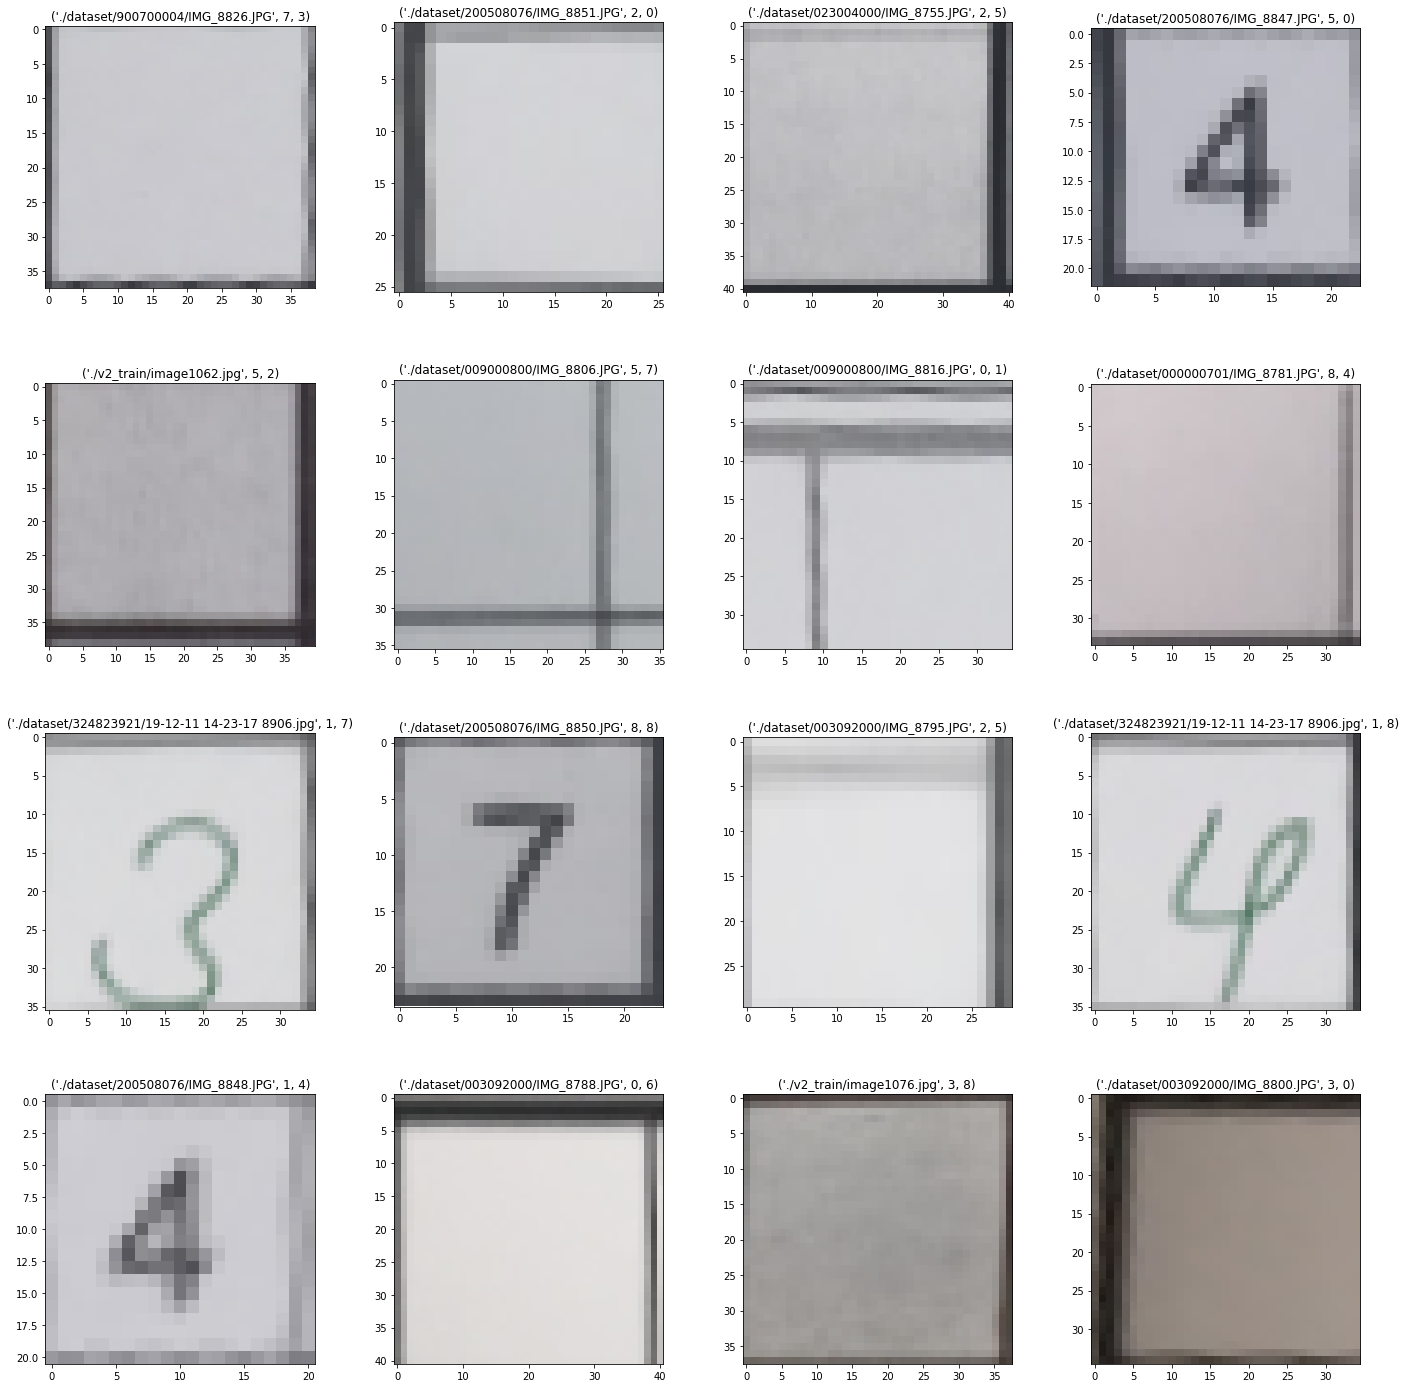

In [10]:
show_images(train["cell_image"], train.index, n_samples=16)

In [11]:
test = dataset[dataset["training"] == False]
print("Testing dataset contains %d samples!" % len(test))

Testing dataset contains 2025 samples!


In [12]:
test

cell_image  ...  training
input_filename                                 cell_row cell_col                                                     ...          
./v2_train/image204.jpg                        0        0         [[[85, 79, 47], [70, 64, 35], [66, 60, 34], [6...  ...     False
                                                        1         [[[70, 69, 40], [68, 68, 41], [67, 67, 41], [6...  ...     False
                                                        2         [[[71, 65, 39], [72, 66, 41], [71, 66, 40], [7...  ...     False
                                                        3         [[[60, 60, 32], [62, 61, 31], [61, 61, 29], [6...  ...     False
                                                        4         [[[66, 65, 36], [68, 66, 37], [69, 67, 40], [7...  ...     False
...                                                                                                             ...  ...       ...
./dataset/234598176/19-12-12 12-50-50 8947.jpg 8        4         [[[175, 178, 186], [166, 169, 176], [161, 164,...  ...     False
                                                        5         [[[155, 158, 166], [158, 161, 168], [160, 163,...  ...     False
                                                        6         [[[170, 173, 183], [171, 173, 185], [180, 183,...  ...     False
                                                        7         [[[171, 175, 186], [165, 169, 181], [158, 162,...  ...     False
                                                        8         [[[161, 165, 176], [153, 157, 168], [146, 150,...  ...     False

[2025 rows x 3 columns]

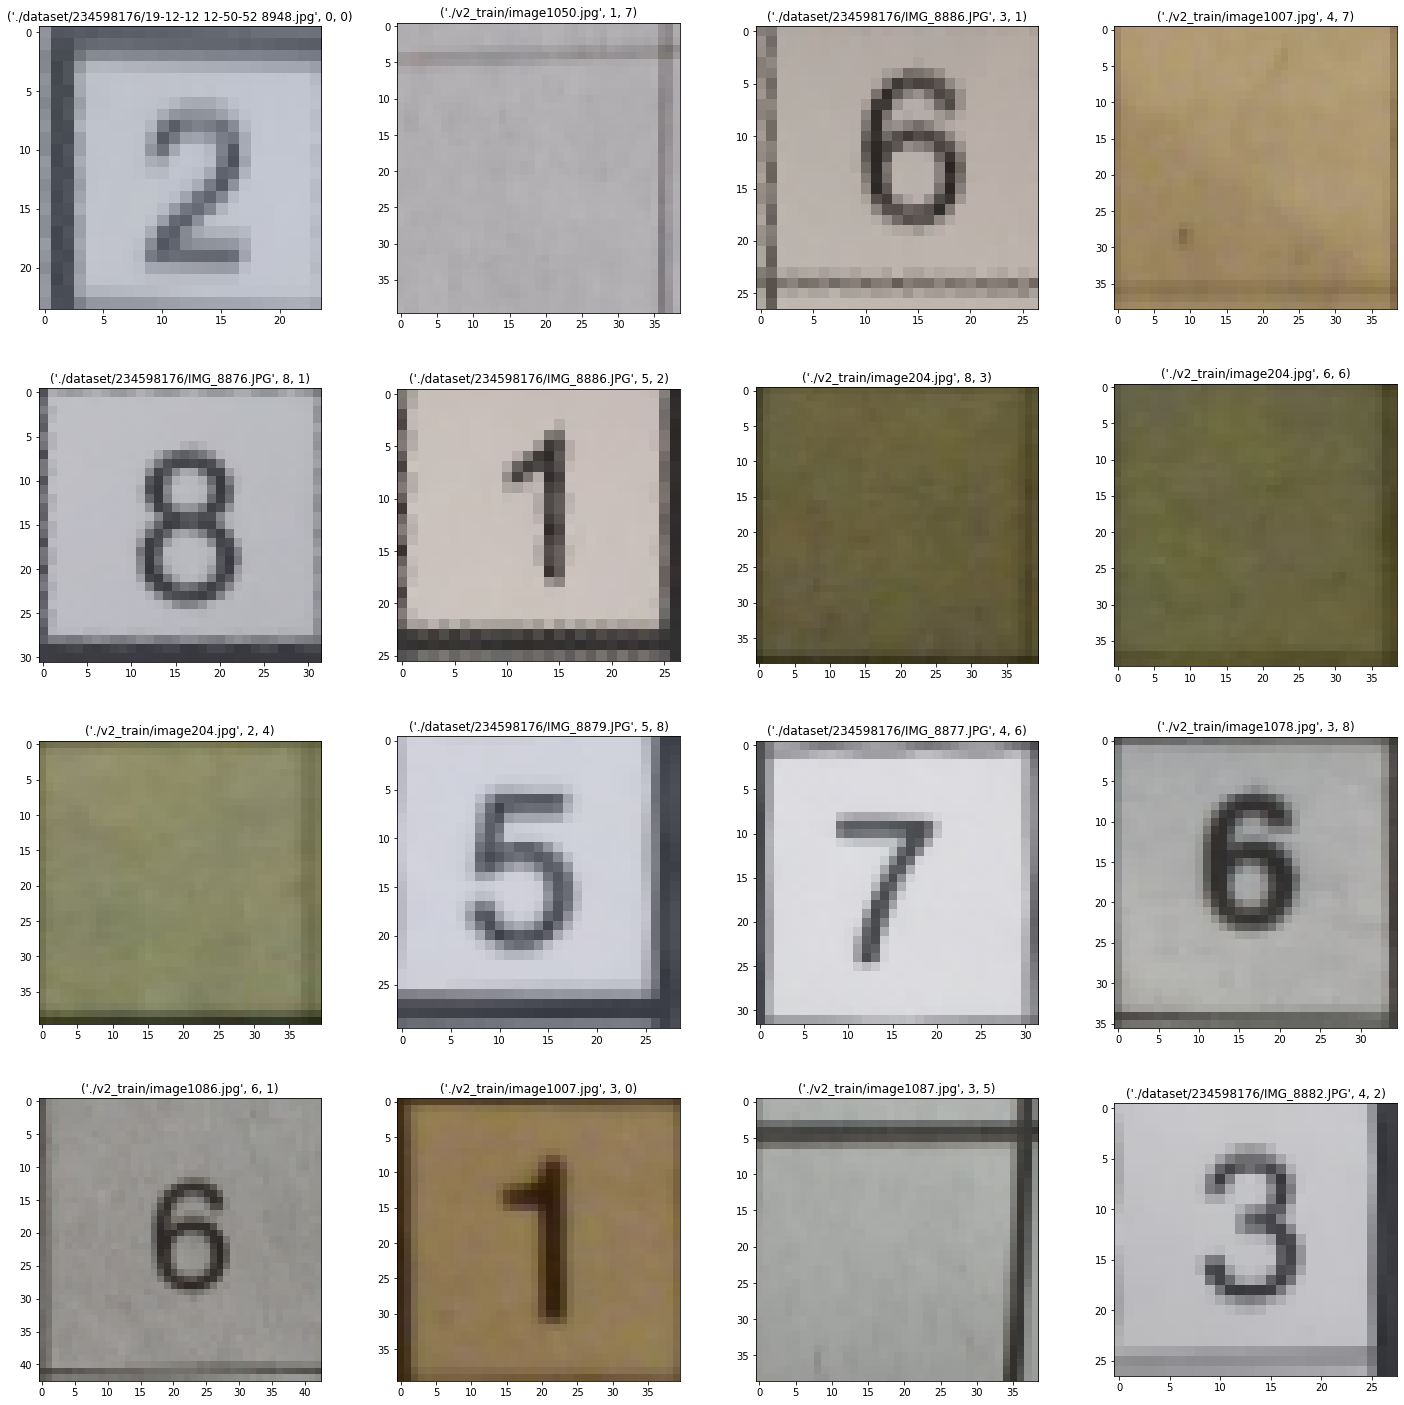

In [13]:
show_images(test["cell_image"], test.index, n_samples=16)

# Recognize digits using neural networks

## Plain MNIST

### Acquire dataset

In [14]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [15]:
print("Train:", mnist_x_train.shape, mnist_y_train.shape)
print("Test:", mnist_x_test.shape, mnist_y_test.shape)

Train: (60000, 28, 28) (60000,)
Test: (10000, 28, 28) (10000,)


In [0]:
mnist_x_train = mnist_x_train.astype("float32") / 255.0
mnist_x_test = mnist_x_test.astype("float32") / 255.0

In [0]:
mnist_x_train = mnist_x_train.reshape(-1, 28, 28, 1)
mnist_x_test = mnist_x_test.reshape(-1, 28, 28, 1)

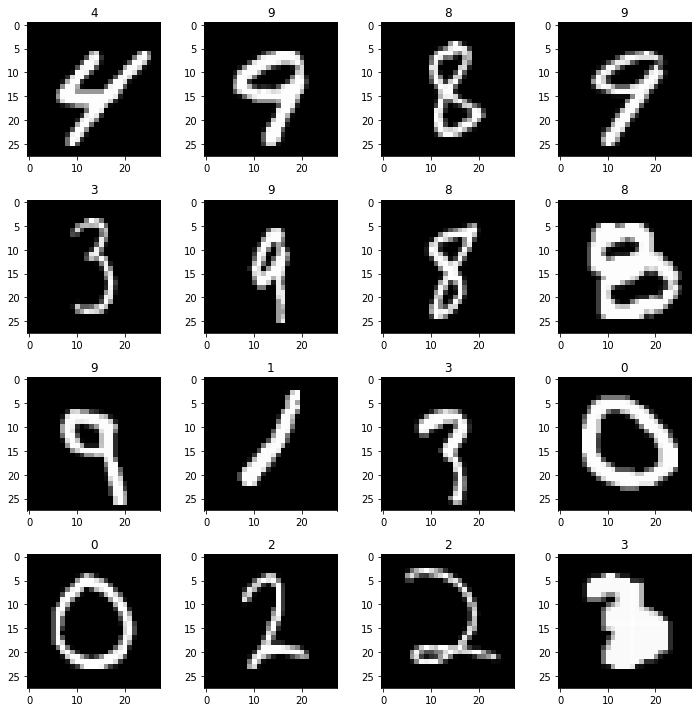

In [18]:
show_images(mnist_x_train, mnist_y_train, cmap="gray", scaling=(2.5, 2.5), n_samples=16)

### Building the model

In [19]:
plainmnist_model = model_input = layers.Input(shape=(28, 28, 1))

plainmnist_model = layers.Conv2D(16, 3, activation="relu")(plainmnist_model)
plainmnist_model = layers.BatchNormalization()(plainmnist_model)
plainmnist_model = layers.Conv2D(32, 3, activation="relu")(plainmnist_model)
plainmnist_model = layers.MaxPool2D()(plainmnist_model)
plainmnist_model = layers.BatchNormalization()(plainmnist_model)
plainmnist_model = layers.Dropout(0.25)(plainmnist_model)

plainmnist_model = layers.Conv2D(64, 3, activation="relu")(plainmnist_model)
plainmnist_model = layers.BatchNormalization()(plainmnist_model)
plainmnist_model = layers.Conv2D(128, 3, activation="relu")(plainmnist_model)
plainmnist_model = layers.GlobalMaxPool2D()(plainmnist_model)
plainmnist_model = layers.BatchNormalization()(plainmnist_model)
plainmnist_model = layers.Dropout(0.25)(plainmnist_model)

#model = layers.Flatten()(model)
#model = layers.Dense(32, activation="relu")(model)
#model = layers.BatchNormalization()(model)
plainmnist_model = layers.Dense(10, activation="softmax")(plainmnist_model)
plainmnist_model = models.Model(model_input, plainmnist_model)
plainmnist_model.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])
plainmnist_model.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 32)        128    

### Fitting the model

In [20]:
early_stopping = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
fit_history = plainmnist_model.fit(mnist_x_train, mnist_y_train, validation_data=(mnist_x_test, mnist_y_test), epochs=100, callbacks=[early_stopping])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 28s 468us/step - loss: 0.1784 - acc: 0.9459 - val_loss: 0.0426 - val_acc: 0.9869
Epoch 2/100
60000/60000 [==============================] - 21s 347us/step - loss: 0.0644 - acc: 0.9795 - val_loss: 0.0283 - val_acc: 0.9908
Epoch 3/100
60000/60000 [==============================] - 21s 348us/step - loss: 0.0528 - acc: 0.9834 - val_loss: 0.0246 - val_acc: 0.9909
Epoch 4/100
60000/60000 [==============================] - 21s 345us/step - loss: 0.0443 - acc: 0.9862 - val_loss: 0.0242 - val_acc: 0.9917
Epoch 5/100
60000/60000 [==============================] - 21s 345us/step - loss: 0.0403 - acc: 0.9875 - val_loss: 0.0212 - val_acc: 0.9927
Epoch 6/100
60000/60000 [==============================] - 21s 353us/step - loss: 0.0382 - acc: 0.9877 - val_loss: 0.0196 - val_acc: 0.9929
Epoch 7/100
60

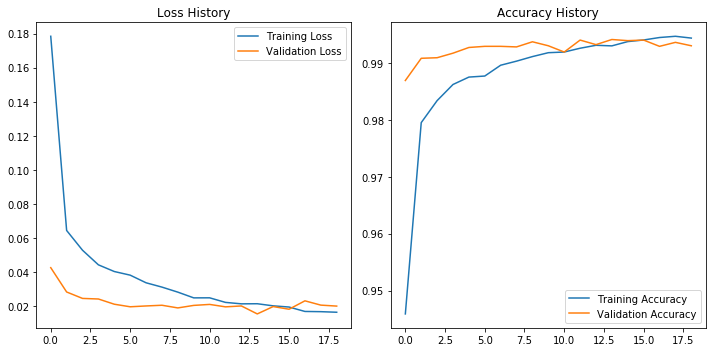

In [21]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Loss History")
plt.plot(fit_history.history["loss"], label="Training Loss")
plt.plot(fit_history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Accuracy History")
plt.plot(fit_history.history["acc"], label="Training Accuracy")
plt.plot(fit_history.history["val_acc"], label="Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
plainmnist_model.evaluate(mnist_x_test, mnist_y_test)

10000/10000 [==============================] - 1s 76us/step


[0.015458225591056543, 0.9941]

### Visualizing the model

Visualizing test image 4475


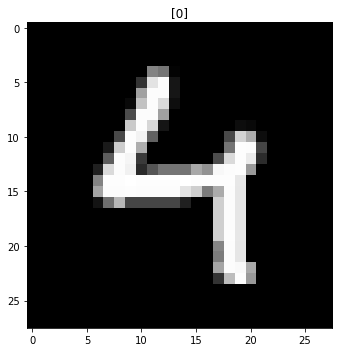

Visualizing layer #1 (conv2d_1)


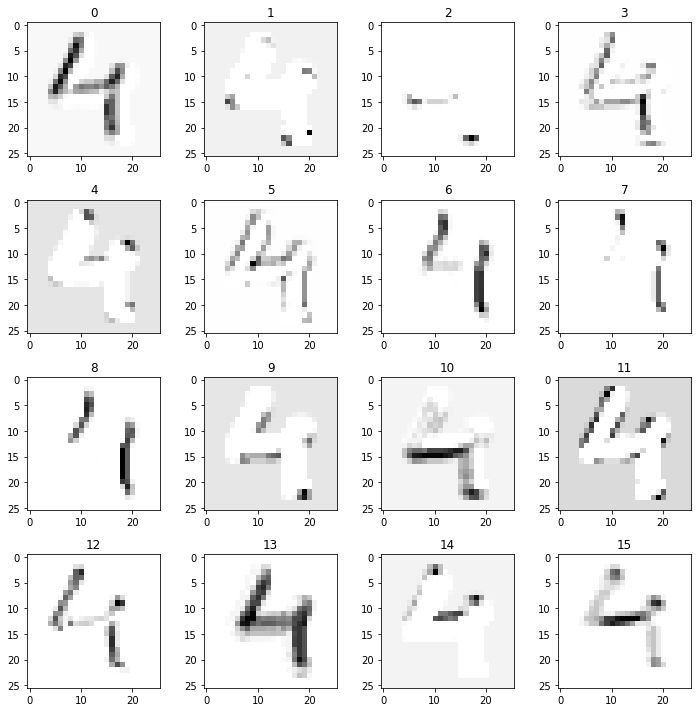

Visualizing layer #3 (conv2d_2)


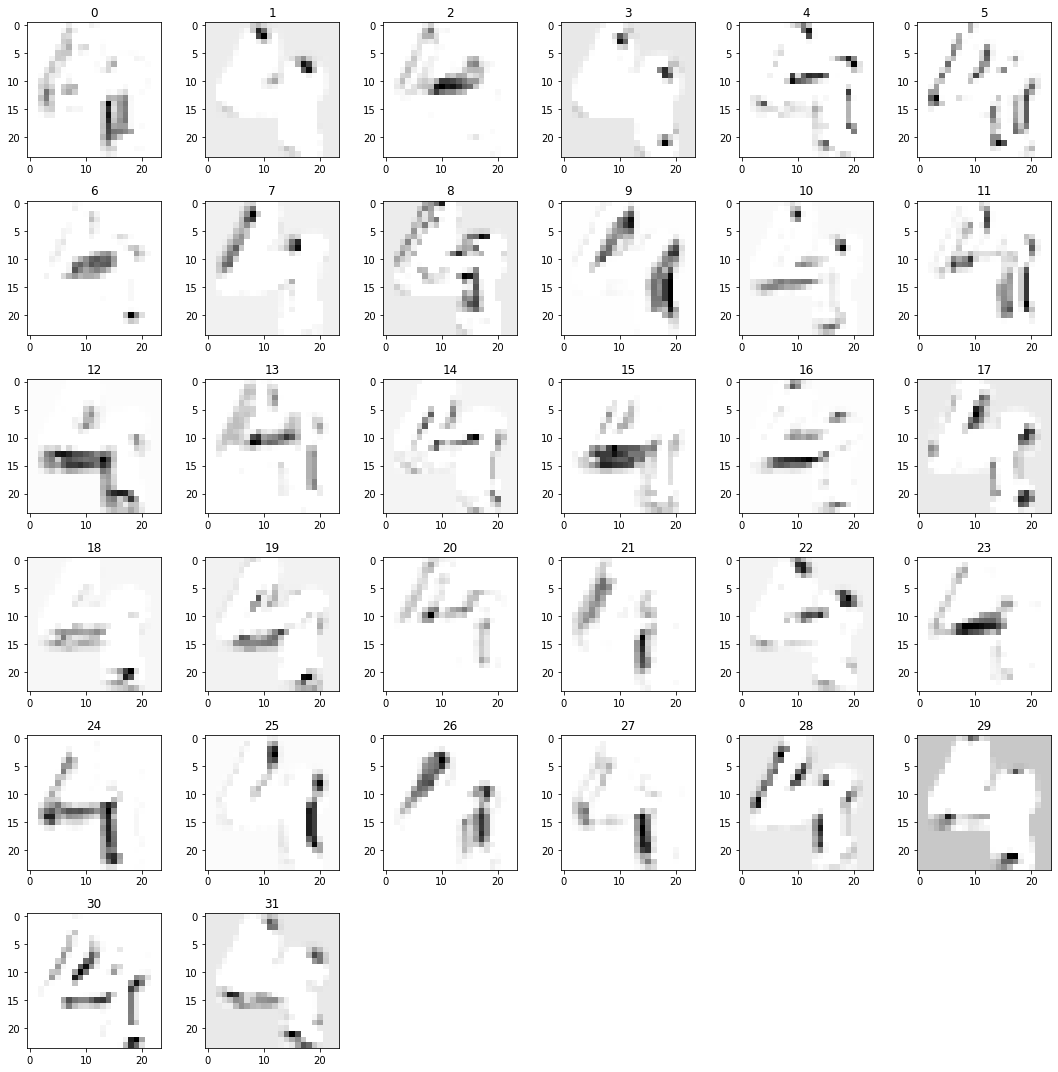

Visualizing layer #7 (conv2d_3)


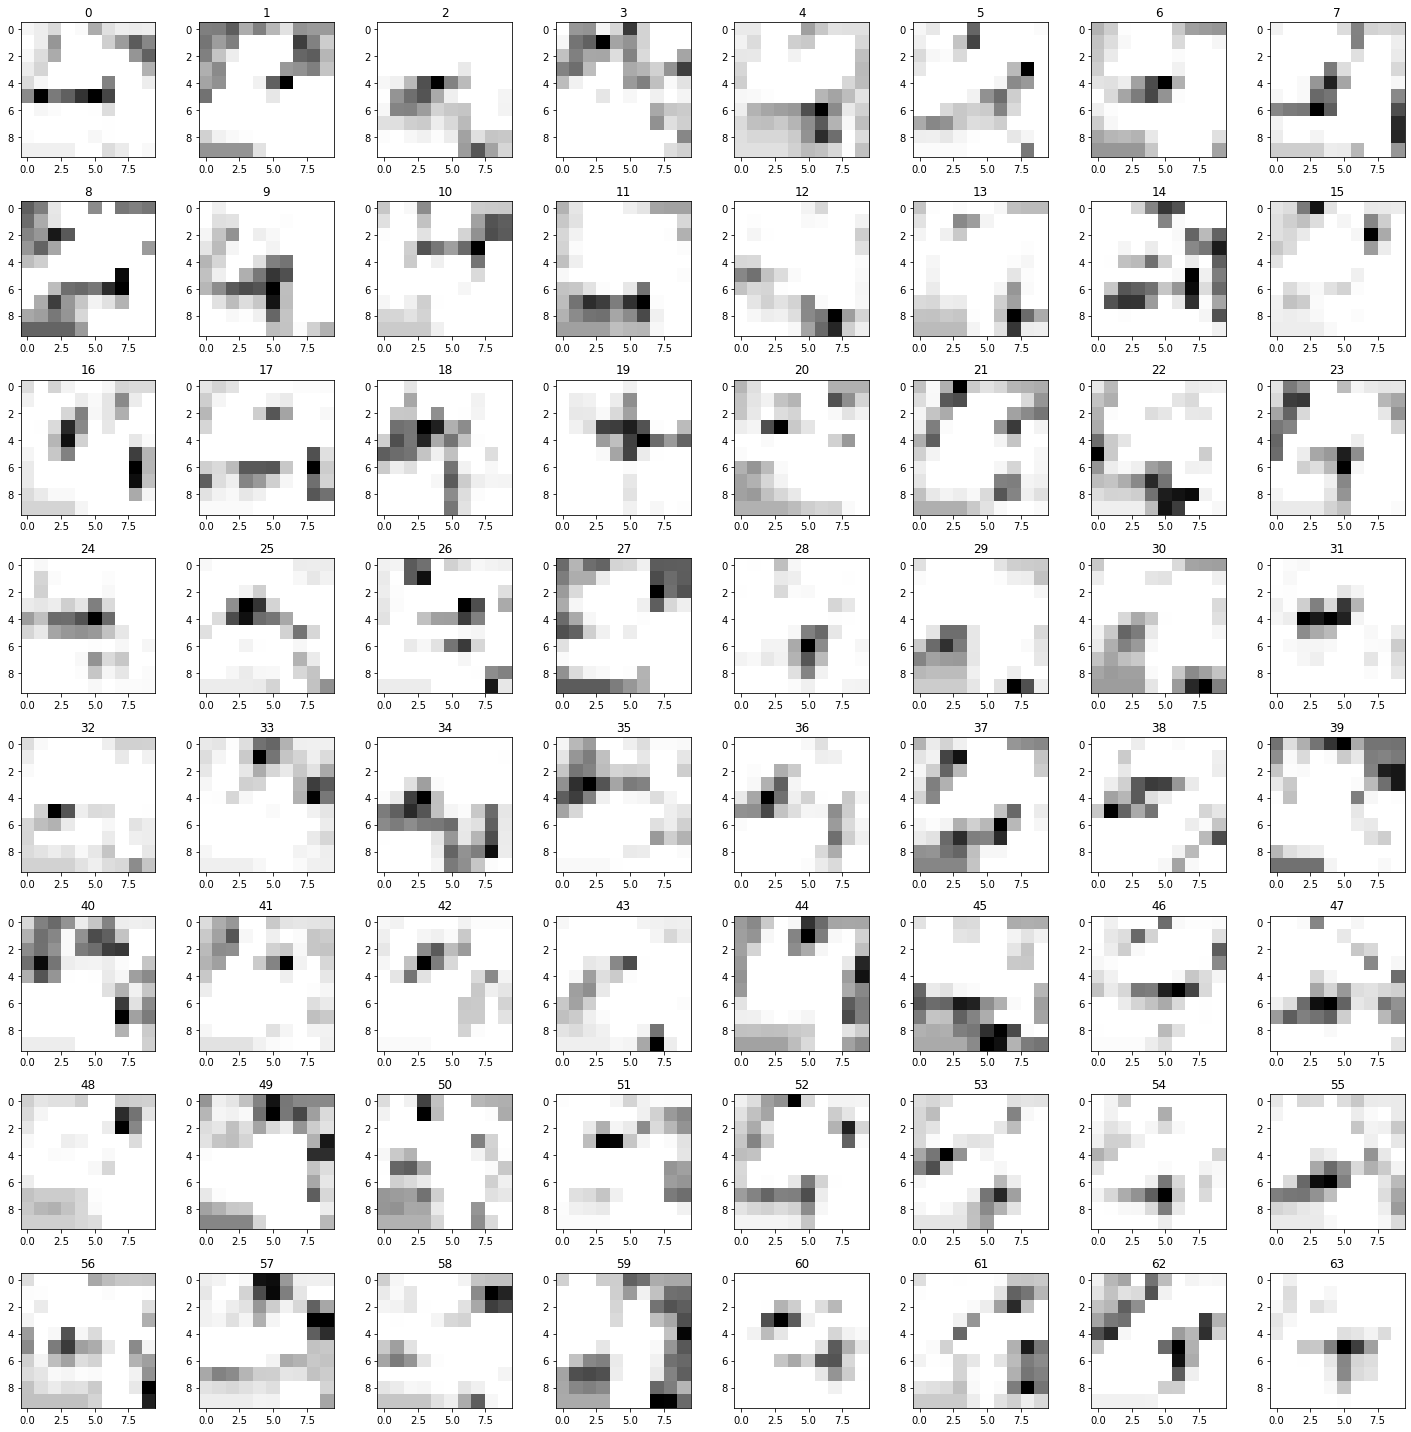

Visualizing layer #9 (conv2d_4)


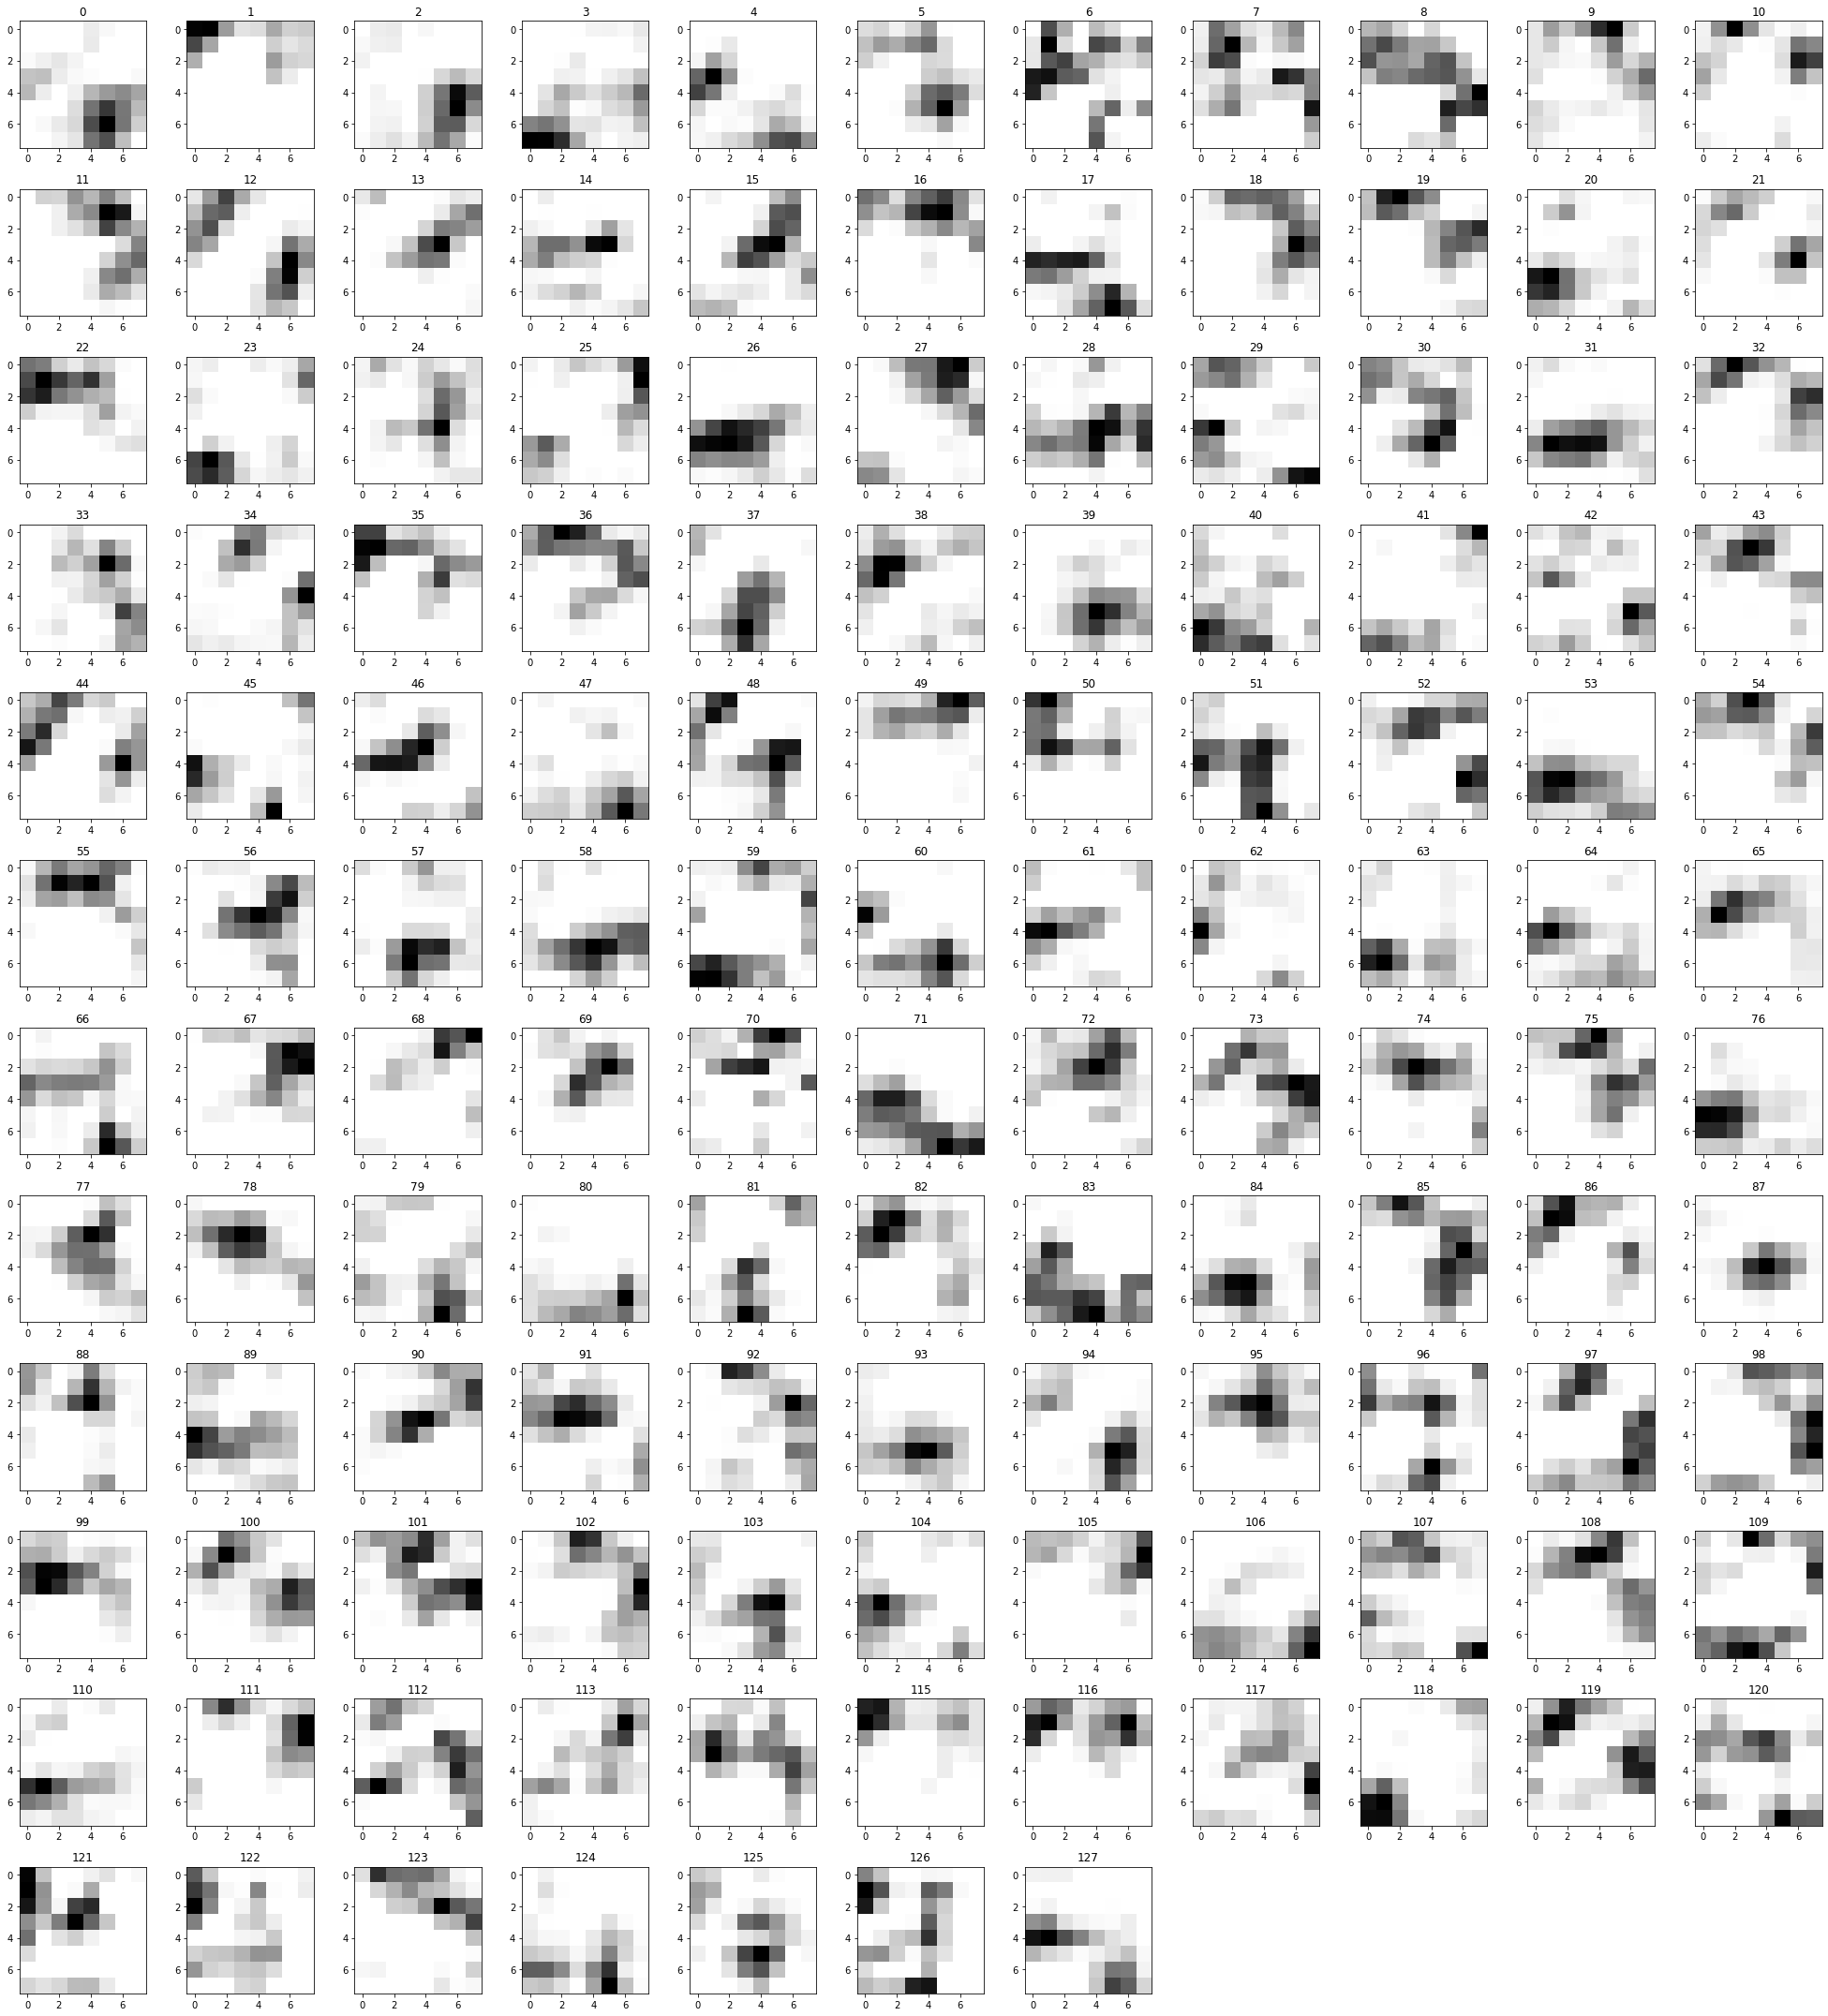

In [23]:
index = random.choice(range(len(mnist_x_test)))
print("Visualizing test image", index)
image = mnist_x_test[index]
show_images([image], cmap="gray")

def nn_get_submodel(model, layer):
  return models.Model(model.input, model.layers[layer].output)

def nn_visualize_layer_activations(model, layer, input):
  submodel = nn_get_submodel(model, layer)
  activations = submodel.predict(np.expand_dims(input, 0))[0]
  activation_channels = np.arange(activations.shape[-1])
  activation_images = [activations[:,:,i] for i in activation_channels]
  show_images(activation_images, activation_channels, cmap="Greys", scaling=(2.5, 2.5), normalize=True)

for i_layer, layer in enumerate(plainmnist_model.layers):
  if layer.name.startswith("conv2d") and len(layer.output.shape) == 4:
    print("Visualizing layer #%d (%s)" % (i_layer, layer.name))
    nn_visualize_layer_activations(plainmnist_model, i_layer, image)

### Evaluating the model

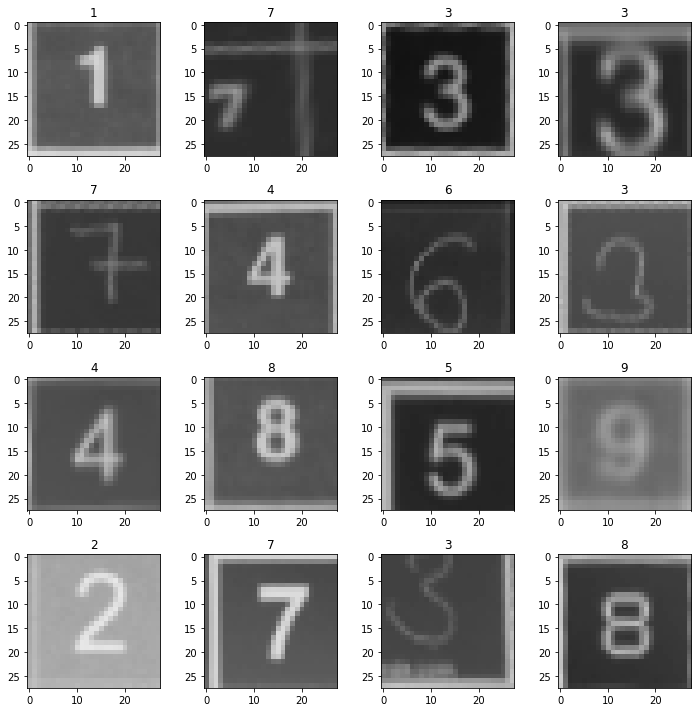

In [24]:
def nn_mnist_preprocess(cell):
  # convert to grayscale
  cell = cv.cvtColor(cell, cv.COLOR_RGB2GRAY)
  # invert:
  cell = 255 - cell
  # resize:
  cell = cv.resize(cell, (28, 28), cv.INTER_AREA)
  # normalize:
  cell = cell.astype("float32") / 255.0
  # expand dims:
  cell = np.expand_dims(cell, axis=2)
  return cell

plainmnist_X_train = np.array([nn_mnist_preprocess(x) for x in train["cell_image"][train["input_digit"] != 0]])
plainmnist_X_test = np.array([nn_mnist_preprocess(x) for x in test["cell_image"][test["input_digit"] != 0]])
plainmnist_Y_train = train["input_digit"][train["input_digit"] != 0].values
plainmnist_Y_test = test["input_digit"][test["input_digit"] != 0].values
show_images(plainmnist_X_train, plainmnist_Y_train, cmap="gray", scaling=(2.5, 2.5), n_samples=16)

In [25]:
plainmnist_model.evaluate(plainmnist_X_test, plainmnist_Y_test)

1534/1534 [==============================] - 0s 103us/step


[8.662594131260839, 0.25358539792518414]

In [26]:
plainmnist_Y_pred = plainmnist_model.predict(plainmnist_X_test)
print(classification_report(plainmnist_Y_test, np.argmax(plainmnist_Y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.31      0.96      0.47       169
           2       0.00      0.00      0.00       166
           3       0.00      0.00      0.00       174
           4       1.00      0.59      0.74       171
           5       0.00      0.00      0.00       169
           6       0.00      0.00      0.00       174
           7       0.00      0.00      0.00       169
           8       0.17      0.74      0.28       168
           9       0.00      0.00      0.00       174

    accuracy                           0.25      1534
   macro avg       0.15      0.23      0.15      1534
weighted avg       0.17      0.25      0.17      1534



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Augmented MNIST

### Acquire dataset

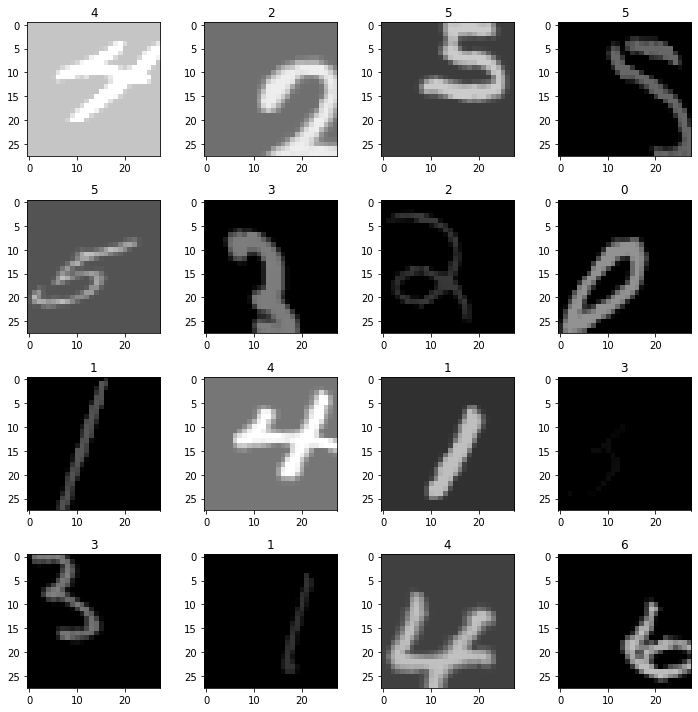

In [27]:
def augmnist_change_brightness(image, factor):
  return image * factor

def augmnist_change_contrast(image, factor):
  return 0.5 + factor * (image - 0.5)

def augmnist_preprocess(image):
  image = image[:,:,0]
  factor = np.random.rand() * 0.5 + 0.5
  image = augmnist_change_brightness(image, factor)
  factor = np.random.rand() * 0.5 + 0.5
  image = augmnist_change_contrast(image, factor)
  image += np.random.randn() * 0.25
  image = np.clip(image, 0.0, 1.0)
  return np.expand_dims(image, axis=2)

generator = ImageDataGenerator(width_shift_range=0.25, height_shift_range=0.25, zoom_range=0.25, shear_range=22.5, preprocessing_function=augmnist_preprocess)
augmnist_generator_train = generator.flow(mnist_x_train, mnist_y_train)
augmnist_generator_test = generator.flow(mnist_x_test, mnist_y_test)
show_images(*augmnist_generator_train[0], cmap="gray", scaling=(2.5, 2.5), n_samples=16)

### Building the model

In [28]:
augmnist_model = model_input = layers.Input(shape=(28, 28, 1))

augmnist_model = layers.Conv2D(16, 3, activation="relu")(augmnist_model)
augmnist_model = layers.BatchNormalization()(augmnist_model)
augmnist_model = layers.Conv2D(32, 3, activation="relu")(augmnist_model)
augmnist_model = layers.MaxPool2D()(augmnist_model)
augmnist_model = layers.BatchNormalization()(augmnist_model)
augmnist_model = layers.Dropout(0.25)(augmnist_model)

augmnist_model = layers.Conv2D(64, 3, activation="relu")(augmnist_model)
augmnist_model = layers.BatchNormalization()(augmnist_model)
augmnist_model = layers.Conv2D(128, 3, activation="relu")(augmnist_model)
augmnist_model = layers.GlobalMaxPool2D()(augmnist_model)
augmnist_model = layers.BatchNormalization()(augmnist_model)
augmnist_model = layers.Dropout(0.25)(augmnist_model)

#model = layers.Flatten()(model)
#model = layers.Dense(32, activation="relu")(model)
#model = layers.BatchNormalization()(model)
augmnist_model = layers.Dense(10, activation="softmax")(augmnist_model)
augmnist_model = models.Model(model_input, augmnist_model)
augmnist_model.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])
augmnist_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_5 (Batch (None, 26, 26, 16)        64        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 32)        0   

### Fitting the model

In [29]:
early_stopping = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
fit_history = augmnist_model.fit_generator(augmnist_generator_train, validation_data=augmnist_generator_test, epochs=100, callbacks=[early_stopping])

Epoch 1/100
1875/1875 [==============================] - 48s 25ms/step - loss: 0.6178 - acc: 0.8077 - val_loss: 0.2044 - val_acc: 0.9371
Epoch 2/100
1875/1875 [==============================] - 46s 24ms/step - loss: 0.2654 - acc: 0.9190 - val_loss: 0.1558 - val_acc: 0.9488
Epoch 3/100
1875/1875 [==============================] - 46s 24ms/step - loss: 0.2179 - acc: 0.9332 - val_loss: 0.3849 - val_acc: 0.8790
Epoch 4/100
1875/1875 [==============================] - 46s 24ms/step - loss: 0.1989 - acc: 0.9378 - val_loss: 0.1298 - val_acc: 0.9576
Epoch 5/100
1875/1875 [==============================] - 46s 25ms/step - loss: 0.1917 - acc: 0.9414 - val_loss: 0.1185 - val_acc: 0.9620
Epoch 6/100
1875/1875 [==============================] - 47s 25ms/step - loss: 0.1740 - acc: 0.9471 - val_loss: 0.1160 - val_acc: 0.9620
Epoch 7/100
1875/1875 [==============================] - 46s 24ms/step - loss: 0.1686 - acc: 0.9483 - val_loss: 0.0992 - val_acc: 0.9670
Epoch 8/100
1875/1875 [==================

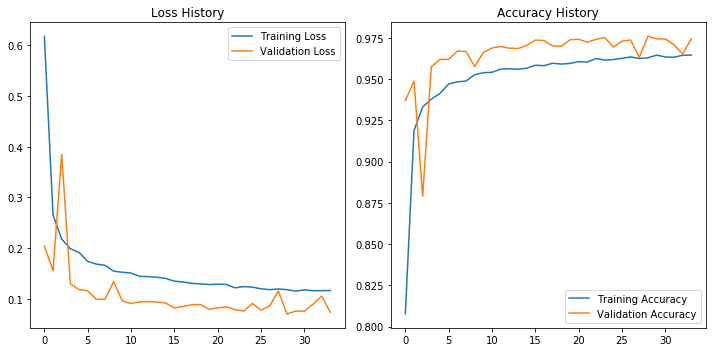

In [30]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Loss History")
plt.plot(fit_history.history["loss"], label="Training Loss")
plt.plot(fit_history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Accuracy History")
plt.plot(fit_history.history["acc"], label="Training Accuracy")
plt.plot(fit_history.history["val_acc"], label="Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

In [31]:
augmnist_model.evaluate_generator(augmnist_generator_test)

[0.0752659799744375, 0.9757]

### Evaluating the model

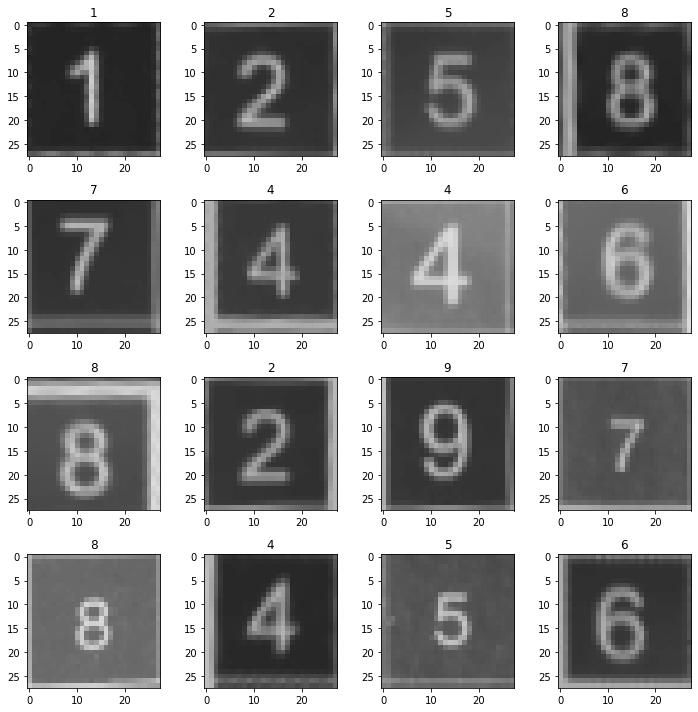

In [32]:
augmnist_X_train = np.array([nn_mnist_preprocess(x) for x in train["cell_image"][train["input_digit"] != 0]])
augmnist_X_test = np.array([nn_mnist_preprocess(x) for x in test["cell_image"][test["input_digit"] != 0]])
augmnist_Y_train = train["input_digit"][train["input_digit"] != 0].values
augmnist_Y_test = test["input_digit"][test["input_digit"] != 0].values
show_images(augmnist_X_test, augmnist_Y_test, cmap="gray", scaling=(2.5, 2.5), n_samples=16)

In [33]:
augmnist_model.evaluate(augmnist_X_test, augmnist_Y_test)

1534/1534 [==============================] - 0s 88us/step


[1.1398658705814566, 0.6310299875061701]

In [34]:
augmnist_Y_pred = augmnist_model.predict(augmnist_X_test)
print(classification_report(augmnist_Y_test, np.argmax(augmnist_Y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.14      0.25       169
           2       0.84      0.13      0.22       166
           3       0.45      0.97      0.61       174
           4       0.82      0.80      0.81       171
           5       0.59      0.95      0.73       169
           6       0.84      0.62      0.71       174
           7       0.80      0.83      0.81       169
           8       0.73      0.89      0.80       168
           9       0.88      0.34      0.50       174

    accuracy                           0.63      1534
   macro avg       0.70      0.57      0.54      1534
weighted avg       0.77      0.63      0.61      1534



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Sudoku dataset


### Acquire dataset

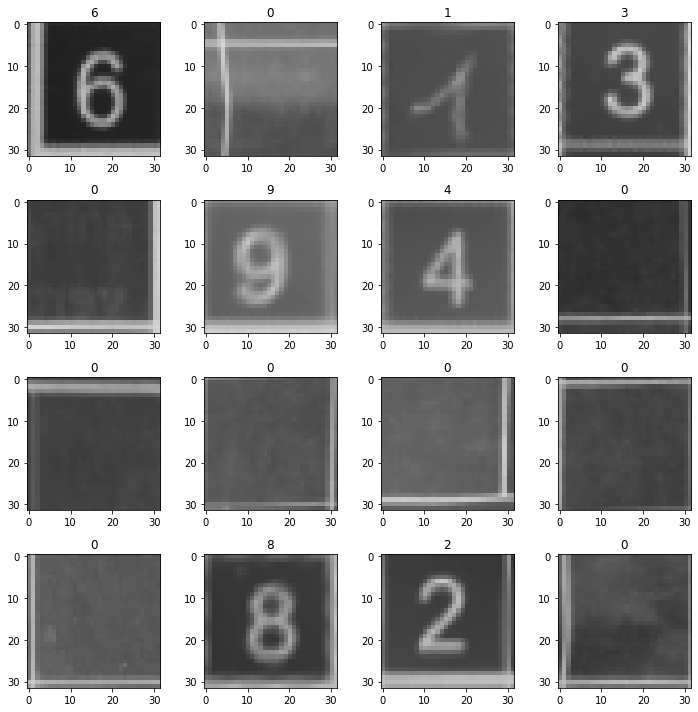

In [35]:
def sudnn_preprocess(cell):
  # convert to grayscale
  cell = cv.cvtColor(cell, cv.COLOR_RGB2GRAY)
  # invert:
  cell = 255 - cell
  # resize:
  cell = cv.resize(cell, (32, 32), cv.INTER_AREA)
  # normalize:
  cell = cell.astype("float32") / 255.0
  # expand dims:
  cell = np.expand_dims(cell, axis=2)
  return cell

sudnn_X_train = np.array([sudnn_preprocess(x) for x in train["cell_image"]])
sudnn_X_test = np.array([sudnn_preprocess(x) for x in test["cell_image"]])
sudnn_Y_train = train["input_digit"].values
sudnn_Y_test = test["input_digit"].values
show_images(sudnn_X_test, sudnn_Y_test, cmap="gray", scaling=(2.5, 2.5), n_samples=16)

### Building the model

In [36]:
sudnn_model = model_input = layers.Input(shape=(32, 32, 1))

sudnn_model = layers.Conv2D(8, 3, activation="relu")(sudnn_model)
sudnn_model = layers.BatchNormalization()(sudnn_model)
sudnn_model = layers.Conv2D(16, 3, activation="relu")(sudnn_model)
sudnn_model = layers.MaxPool2D()(sudnn_model)
sudnn_model = layers.BatchNormalization()(sudnn_model)
sudnn_model = layers.Dropout(0.25)(sudnn_model)

sudnn_model = layers.Conv2D(16, 3, activation="relu")(sudnn_model)
sudnn_model = layers.BatchNormalization()(sudnn_model)
sudnn_model = layers.Conv2D(32, 3, activation="relu")(sudnn_model)
sudnn_model = layers.GlobalMaxPool2D()(sudnn_model)
sudnn_model = layers.BatchNormalization()(sudnn_model)
sudnn_model = layers.Dropout(0.25)(sudnn_model)

#model = layers.Flatten()(model)
#model = layers.Dense(32, activation="relu")(model)
#model = layers.BatchNormalization()(model)
sudnn_model = layers.Dense(10, activation="softmax")(sudnn_model)
sudnn_model = models.Model(model_input, sudnn_model)
sudnn_model.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])
sudnn_model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 30, 8)         80        
_________________________________________________________________
batch_normalization_9 (Batch (None, 30, 30, 8)         32        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 16)        1168      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 14, 14, 16)        64        
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 16)        0   

### Fitting the model

In [37]:
from sklearn.utils.class_weight import compute_class_weight
class_weight = compute_class_weight("balanced", np.unique(sudnn_Y_train), sudnn_Y_train)
class_weight

array([0.19441135, 1.76142857, 1.86504202, 1.81620295, 1.98515206,
       1.92322357, 1.70986133, 1.95026362, 1.89045997, 1.81323529])

In [38]:
from keras import callbacks
early_stopping = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
fit_history = sudnn_model.fit(sudnn_X_train, sudnn_Y_train, 
                              validation_data=(sudnn_X_test, sudnn_Y_test), 
                              epochs=100, callbacks=[early_stopping], 
                              class_weight=class_weight)

Train on 11097 samples, validate on 2025 samples
Epoch 1/100
11097/11097 [==============================] - 5s 434us/step - loss: 1.0579 - acc: 0.6615 - val_loss: 1.0372 - val_acc: 0.6168
Epoch 2/100
11097/11097 [==============================] - 4s 320us/step - loss: 0.4147 - acc: 0.8757 - val_loss: 0.1806 - val_acc: 0.9481
Epoch 3/100
11097/11097 [==============================] - 4s 318us/step - loss: 0.2730 - acc: 0.9223 - val_loss: 0.1563 - val_acc: 0.9556
Epoch 4/100
11097/11097 [==============================] - 4s 327us/step - loss: 0.2053 - acc: 0.9405 - val_loss: 0.1195 - val_acc: 0.9689
Epoch 5/100
11097/11097 [==============================] - 4s 317us/step - loss: 0.1600 - acc: 0.9540 - val_loss: 0.1116 - val_acc: 0.9640
Epoch 6/100
11097/11097 [==============================] - 3s 309us/step - loss: 0.1394 - acc: 0.9613 - val_loss: 0.0997 - val_acc: 0.9714
Epoch 7/100
11097/11097 [==============================] - 4s 339us/step - loss: 0.1187 - acc: 0.9665 - val_loss: 0.1

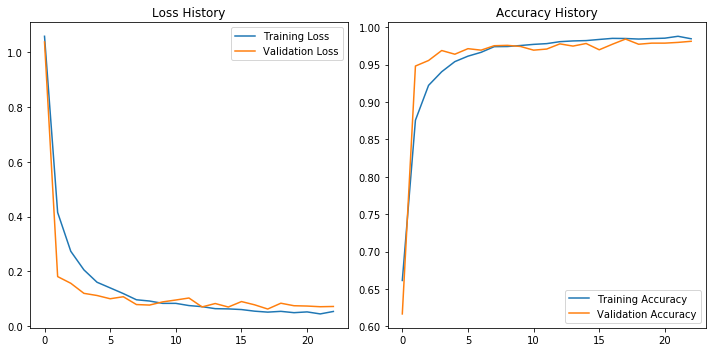

In [39]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Loss History")
plt.plot(fit_history.history["loss"], label="Training Loss")
plt.plot(fit_history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Accuracy History")
plt.plot(fit_history.history["acc"], label="Training Accuracy")
plt.plot(fit_history.history["val_acc"], label="Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
sudnn_model.evaluate(sudnn_X_test, sudnn_Y_test)

2025/2025 [==============================] - 0s 83us/step


[0.062217525166515436, 0.9841975309230663]

### Evaluating the model

In [41]:
sudnn_model.evaluate(sudnn_X_test, sudnn_Y_test)

2025/2025 [==============================] - 0s 76us/step


[0.062217525166515436, 0.9841975309230663]

In [42]:
sudnn_Y_pred = sudnn_model.predict(sudnn_X_test)
print(classification_report(sudnn_Y_test, np.argmax(sudnn_Y_pred, axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       491
           1       1.00      1.00      1.00       169
           2       0.95      1.00      0.98       166
           3       0.97      1.00      0.99       174
           4       1.00      0.98      0.99       171
           5       0.98      0.97      0.98       169
           6       0.98      0.97      0.98       174
           7       1.00      0.93      0.97       169
           8       0.95      0.99      0.97       168
           9       0.98      0.97      0.97       174

    accuracy                           0.98      2025
   macro avg       0.98      0.98      0.98      2025
weighted avg       0.98      0.98      0.98      2025



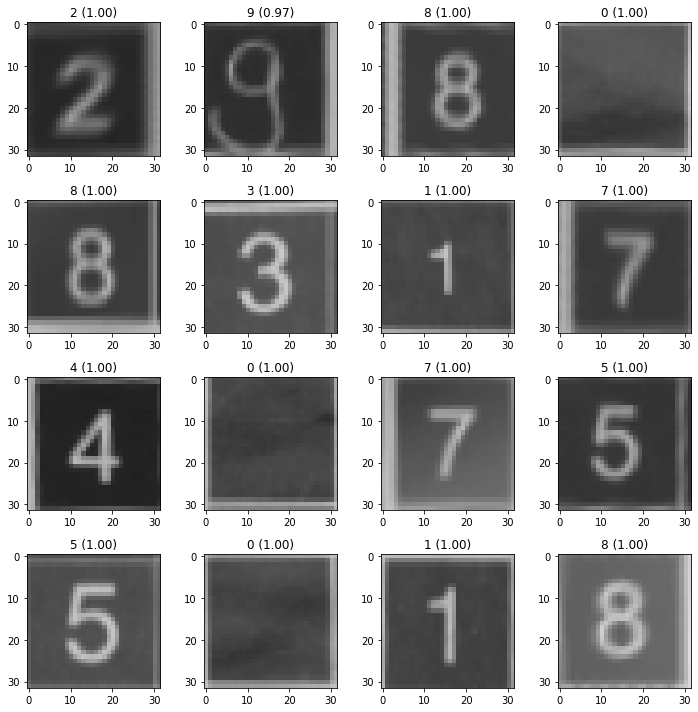

In [43]:
show_images(sudnn_X_test, ["%d (%0.2f)" % (np.argmax(pred), np.max(pred)) for pred in sudnn_Y_pred], cmap="gray", scaling=(2.5, 2.5), n_samples=16)

# Predictions

In [76]:
x = [sudnn_preprocess(cell) for cell in dataset["cell_image"]]
x = np.array(x)
x.shape

(13122, 32, 32, 1)

In [78]:
dataset["recog_x"] = x.tolist()
dataset["recog_x"]

input_filename                    cell_row  cell_col
./v2_train/image1059.jpg          0         0           [[[0.6823529601097107], [0.7529411911964417], ...
                                            1           [[[0.7647058963775635], [0.7411764860153198], ...
                                            2           [[[0.7607843279838562], [0.729411780834198], [...
                                            3           [[[0.729411780834198], [0.6941176652908325], [...
                                            4           [[[0.7333333492279053], [0.6823529601097107], ...
                                                                              ...                        
./dataset/009000800/IMG_8824.JPG  8         4           [[[0.572549045085907], [0.5803921818733215], [...
                                            5           [[[0.3764705955982208], [0.35686275362968445],...
                                            6           [[[0.3686274588108063], [0.3686274588108063

In [79]:
y = sudnn_model.predict(x)
y.shape

(13122, 10)

In [80]:
dataset["recog_y"] = y.tolist()
dataset["recog_y"]

input_filename                    cell_row  cell_col
./v2_train/image1059.jpg          0         0           [0.9999979734420776, 5.991104217173415e-07, 5....
                                            1           [5.119125609520658e-12, 1.7293469989354548e-09...
                                            2           [0.9999964237213135, 9.48106446685415e-07, 1.1...
                                            3           [5.418193893547141e-08, 0.9999682903289795, 1....
                                            4           [1.4339662790519014e-10, 8.398836143896915e-06...
                                                                              ...                        
./dataset/009000800/IMG_8824.JPG  8         4           [0.0006579550099559128, 0.9838249683380127, 0....
                                            5           [0.9999963045120239, 1.9616556983237388e-06, 1...
                                            6           [0.9999074935913086, 4.1090512240771204e-05

In [84]:
digit = np.argmax(y, axis=1)
digit.shape

(13122,)

In [85]:
dataset["recog_digit"] = digit.tolist()
dataset["recog_digit"]

input_filename                    cell_row  cell_col
./v2_train/image1059.jpg          0         0           0
                                            1           3
                                            2           0
                                            3           1
                                            4           4
                                                       ..
./dataset/009000800/IMG_8824.JPG  8         4           1
                                            5           0
                                            6           0
                                            7           0
                                            8           0
Name: recog_digit, Length: 13122, dtype: int64

# Export

In [0]:
sudnn_model.save("./sudoku_recognition_model.h5")

In [0]:
!cp "./sudoku_recognition_model.h5" "./drive/My Drive/sudoku_recognition_model.h5"

In [89]:
df = dataset[["recog_x", "recog_y", "recog_digit"]]
df

recog_x  ... recog_digit
input_filename                   cell_row cell_col                                                     ...            
./v2_train/image1059.jpg         0        0         [[[0.6823529601097107], [0.7529411911964417], ...  ...           0
                                          1         [[[0.7647058963775635], [0.7411764860153198], ...  ...           3
                                          2         [[[0.7607843279838562], [0.729411780834198], [...  ...           0
                                          3         [[[0.729411780834198], [0.6941176652908325], [...  ...           1
                                          4         [[[0.7333333492279053], [0.6823529601097107], ...  ...           4
...                                                                                               ...  ...         ...
./dataset/009000800/IMG_8824.JPG 8        4         [[[0.572549045085907], [0.5803921818733215], [...  ...           1
                                          5         [[[0.3764705955982208], [0.35686275362968445],...  ...           0
                                          6         [[[0.3686274588108063], [0.3686274588108063], ...  ...           0
                                          7         [[[0.38823530077934265], [0.38823530077934265]...  ...           0
                                          8         [[[0.4313725531101227], [0.4313725531101227], ...  ...           0

[13122 rows x 3 columns]

In [0]:
df.to_pickle("./sudoku_recognition_output.bz2")

In [0]:
!cp "./sudoku_recognition_output.bz2" "./drive/My Drive/sudoku_recognition_output.bz2"